In [0]:
import os
import cv2
import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import functools
import itertools

In [0]:
import matplotlib.pyplot as plt
import PIL 
from PIL import Image
import random

In [0]:
load_again = True 
if load_again:
  folder  = '/content/drive/My Drive/Datasets/face_comic.zip'
  !cp "{folder}" .
  !unzip -q face_comic.zip
  !rm -r face_comic.zip

In [0]:
def apply_gaussian_blur(img):
  n = img.shape[0]
  for i in range(n):
    img[i]= cv2.GaussianBlur(img[i],(5,5),0)

In [0]:
slice_idx = 1600
path_dir = os.path.curdir
face_dataset = np.load(path_dir+'/face.npy',allow_pickle=True)
comic_dataset = np.load(path_dir+'/comic.npy',allow_pickle=True)
train_face = face_dataset[:slice_idx]
train_comic = comic_dataset[:slice_idx]
test_face = face_dataset[slice_idx:2000]
test_comic = comic_dataset[slice_idx:2000]
train_face = train_face.reshape(-1,128,128,3)
train_comic = train_comic.reshape(-1,128,128,3)
test_face = test_face.reshape(-1,128,128,3)
test_comic = test_comic.reshape(-1,128,128,3)
apply_gaussian_blur(train_face)
apply_gaussian_blur(train_comic)

In [0]:
test_comic.shape

(400, 128, 128, 3)

In [0]:

class ResnetGenerator(nn.Module):
    """
    This code is inspired from (https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU()]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU()]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU()]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU()]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [0]:
class NLayerDiscriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):

        super(NLayerDiscriminator, self).__init__()
        if type(norm_layer) == functools.partial:  # no need to use bias as BatchNorm2d has affine parameters
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        return self.model(input)


In [0]:
class GANLoss(nn.Module):
    """Define different GAN objectives"""

    def __init__(self, target_real_label=1.0, target_fake_label=0.0):

        super(GANLoss, self).__init__()
        self.register_buffer('real_label', torch.tensor(target_real_label))
        self.register_buffer('fake_label', torch.tensor(target_fake_label))
        self.loss = nn.MSELoss()

    def get_target_tensor(self, prediction, target_is_real):

        if target_is_real:
            target_tensor = self.real_label.to(device)
        else:
            target_tensor = self.fake_label
        return target_tensor.expand_as(prediction).to(device)

    def __call__(self, prediction, target_is_real):
      
        target_tensor = self.get_target_tensor(prediction, target_is_real)
        loss = self.loss(prediction, target_tensor)
    
        return loss

In [0]:
device = torch.device("cuda:0")

In [0]:
torch.cuda.is_available()

True

In [0]:
# net = Net().to(device)
gen_xy = ResnetGenerator(3,3).to(device)
gen_yx = ResnetGenerator(3,3).to(device)
disc_x = NLayerDiscriminator(3).to(device)
disc_y = NLayerDiscriminator(3).to(device)

In [0]:
optimizer_g = optim.Adam(itertools.chain(gen_xy.parameters(),gen_yx.parameters()),lr=0.0002)
optimizer_d = optim.Adam(itertools.chain(disc_x.parameters(),disc_y.parameters()),lr=0.0002)

In [0]:
identity_l = nn.L1Loss()
gan_l = GANLoss()
cycle_l = nn.L1Loss()

In [0]:
def imshow(img):
  # plot_image = img.view(3,128,128).numpy()*255.0
  # plt.imshow(np.transpose(img,(1,2,0)))
  plt.imshow(img)
  plt.show()

In [0]:
def train_step(real_x,real_y):


  # G_xy
  optimizer_g.zero_grad()

  fake_y = gen_xy(real_x)
  prediction_y = disc_x(fake_y)
  cycled_x = gen_yx(fake_y)

  loss_id_y = identity_l(gen_xy(real_y),real_y)
  loss_cyc_x = cycle_l(real_x,cycled_x)*10
  loss_1 = gan_l(prediction_y,True) 

  loss_x = loss_id_y + loss_cyc_x + loss_1
  loss_x.backward(retain_graph=True)
  optimizer_g.step()


  # G_yx
  optimizer_g.zero_grad()

  fake_x = gen_yx(real_y)
  prediction_x = disc_y(fake_x)
  cycled_y = gen_xy(fake_x)

  loss_id_x = identity_l(gen_yx(real_x),real_x)
  loss_cyc_y = cycle_l(real_y,cycled_y)*10
  loss_2 = gan_l(prediction_x,True) 

  loss_y = loss_id_x + loss_cyc_y + loss_2
  loss_y.backward(retain_graph=True)
  optimizer_g.step()

  # Discriminator loss

  # d_x

  optimizer_d.zero_grad()

  pred_real = disc_x(real_y)
  real_loss_d_x = gan_l(pred_real,True)

  pred_fake = disc_x(fake_y.clone().detach())
  fake_loss_d_x = gan_l(pred_fake,False)

  loss_d_x = (real_loss_d_x+fake_loss_d_x)*0.5
  loss_d_x.backward()
  optimizer_d.step()

  # d_y
  
  optimizer_d.zero_grad()

  pred_real = disc_y(real_x)
  real_loss_d_y = gan_l(pred_real,True)

  pred_fake = disc_y(fake_x.clone().detach())
  fake_loss_d_y = gan_l(pred_fake,False)

  loss_d_y = (real_loss_d_y+fake_loss_d_y)*0.5
  loss_d_y.backward()
  optimizer_d.step()

  # print("Losses: ",gen_loss.item(),disc_x_loss.item(),disc_y_loss.item())


In [0]:
two_data = list(zip(train_face,train_comic))
train_x = torch.utils.data.DataLoader(two_data,batch_size=1,shuffle=True)

In [0]:
test_val = torch.Tensor(test_face)
test_val = test_val.type(torch.FloatTensor)
test_val = test_val/255.0

In [0]:
test_val.shape

torch.Size([400, 128, 128, 3])

In [0]:
model_save_name_1 = 'gen_xy'
model_save_name_2 = 'gen_yx'
model_save_name_3 = 'disc_x'
model_save_name_4 = 'disc_y'
path1 = F"/content/gdrive/My Drive/Models/cyclegan/face_comic/{model_save_name_1}"
path2 = F"/content/gdrive/My Drive/Models/cyclegan/face_comic/{model_save_name_2}"
path3 = F"/content/gdrive/My Drive/Models/cyclegan/face_comic/{model_save_name_3}"
path4 = F"/content/gdrive/My Drive/Models/cyclegan/face_comic/{model_save_name_4}"

In [0]:
def load_models():
  gen_xy.load_state_dict(torch.load(path1))
  gen_yx.load_state_dict(torch.load(path2))
  disc_x.load_state_dict(torch.load(path3))
  disc_y.load_state_dict(torch.load(path4))

In [0]:
def save_models():
  torch.save(gen_xy.state_dict(),path1)
  torch.save(gen_yx.state_dict(),path2)
  torch.save(disc_x.state_dict(),path3)
  torch.save(disc_y.state_dict(),path4)

In [0]:
def train():
  for i in range(40):
    print(i)
    for x,y in train_x:
      # print(j)
      x = x.type(torch.cuda.FloatTensor)
      x.requires_grad_(requires_grad=True)
      y = y.type(torch.cuda.FloatTensor)
      y.requires_grad_(requires_grad=True)
      x = x/255.0
      y = y/255.0
      real_x = x.view(-1,3,128,128).to(device)
      real_y = y.view(-1,3,128,128).to(device)
      train_step(real_x,real_y)

    sample_output = gen_xy(test_val[75].view(-1,3,128,128).to(device)).to(torch.device("cpu"))
    sample_img = sample_output.detach().numpy().reshape(128,128,3)
    imshow((sample_img*255).astype(np.uint8)) 

    if (i+1)%20==0:
      save_models()  

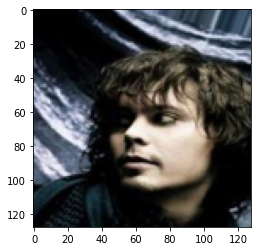

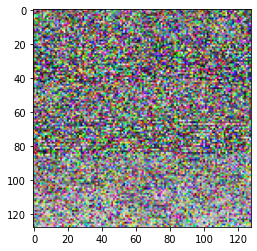

In [0]:
m = 75
test_img = test_val[m].numpy()
test_img = test_img.reshape(128,128,3)
imshow(test_img)


sample_output = gen_xy(test_val[m].view(-1,3,128,128).to(device)).to(torch.device("cpu"))
sample_img = sample_output.detach().numpy().reshape(128,128,3)
imshow((sample_img*255).astype(np.uint8)) 

In [0]:
train()

0


KeyboardInterrupt: ignored